# Binary Image Classification using Simple CNN on Pneumonia X-ray Dataset

In [1]:
!pip install tensorflow scikit-learn --quiet

### Download & Use Chest X-ray

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:19<00:00, 39.6MB/s]
100% 2.29G/2.29G [00:19<00:00, 130MB/s] 


In [ ]:
!unzip chest-xray-pneumonia.zip

### Import Required Libraries
- TensorFlow/Keras for building and training the CNN
- ImageDataGenerator for loading and augmenting image data
- Scikit-learn for handling class imbalance and evaluation metrics
- Matplotlib/Seaborn for visualizing the confusion matrix

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Set Dataset Paths
- Set the paths for train, validation, and test directories of the Chest X-ray dataset.


In [7]:
train_path = "chest_xray/chest_xray/train"
val_path   = "chest_xray/chest_xray/val"
test_path  = "chest_xray/chest_xray/test"

### Image Dimensions and Parameters
- Set image size to resize all images uniformly (e.g., 150x150)
- Define batch size for data loading

In [8]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

### Create Data Generators with Augmentation
- Apply real-time image augmentations like rotation, zoom, and flip on training data
- Use only rescaling for validation and test sets to avoid data leakage
- `flow_from_directory` loads images directly from folder structure:
  - `/PNEUMONIA`, `/NORMAL` as subfolders under train/val/test

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Compute Class Weights
- Use `compute_class_weight()` to address imbalance in training data
- Pneumonia images usually outnumber Normal, so this helps balance learning


In [11]:
### Compute Class Weights to Handle Imbalance
classes = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

In [12]:
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


### Define the Simple CNN Architecture
- Three convolutional blocks (Conv2D + ReLU + MaxPool)
- Flattening layer followed by Dense layers
- Final output layer with 1 unit and sigmoid activation for binary output


In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the Model
- Loss: `binary_crossentropy` for binary classification
- Optimizer: `adam` for adaptive learning
- Metric: Accuracy

In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### Train the Model with Class Weights
- Pass `class_weight` during training to correct imbalance
- Validate on clean, unaugmented validation data

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.5784 - loss: 0.6616 - val_accuracy: 0.6875 - val_loss: 0.9869
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 453ms/step - accuracy: 0.8738 - loss: 0.3228 - val_accuracy: 0.8125 - val_loss: 0.4897
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 443ms/step - accuracy: 0.8908 - loss: 0.2758 - val_accuracy: 0.8125 - val_loss: 0.3692
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.8927 - loss: 0.2706 - val_accuracy: 0.8750 - val_loss: 0.3786
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.9110 - loss: 0.2365 - val_accuracy: 0.6875 - val_loss: 0.9079


### Evaluate on the Test Set
- Check accuracy on unseen test data
- Keep shuffle=False to align predictions with actual labels

In [16]:
loss, acc = model.evaluate(val_data)
print(f"Test Accuracy: {acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6875 - loss: 0.9079
Test Accuracy: 0.6875


### Predict and Visualize Results
- Convert sigmoid output to binary predictions with threshold 0.5
- Use confusion matrix to visualize true vs predicted class distribution


In [17]:
y_pred = model.predict(val_data) > 0.5
y_true = val_data.classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


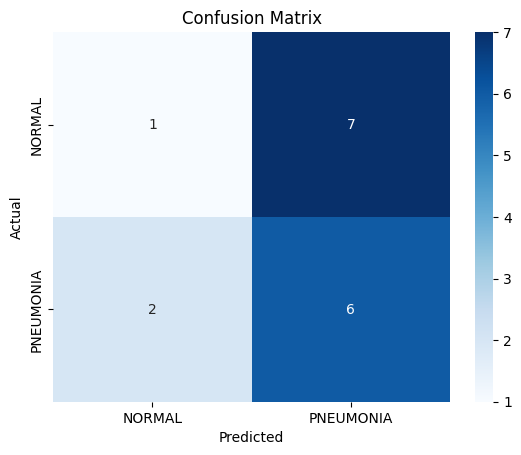

In [18]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices, yticklabels=val_data.class_indices)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Generate Classification Report
- Show precision, recall, F1-score for each class
- Helps identify performance bias between pneumonia and normal categories

In [20]:
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.33      0.12      0.18         8
   PNEUMONIA       0.46      0.75      0.57         8

    accuracy                           0.44        16
   macro avg       0.40      0.44      0.38        16
weighted avg       0.40      0.44      0.38        16

